# Извлечение аббревиатур

Извлечение происходит двухэтапно:
1. Сначала "наивно" достаются все аббревиатуры по следущим правилам:
    + Если больше половины букв в слове - заглавные, то это аббревиатура
    + Исключение это возможные инициалы сотрудинков ("М.П.", "М.П" и тп)
    + Потом эти аббревиатуры чистятся - оставляем только буквы и знаки "-", "."

2. Приводим аббревиатуры в одинаковый вид, разделяем аббревиатуры

    После первого этапа остаются аббревиатуры, которые могут писаться несколькими способами - "ЭХО-КГ", "ЭХОКГ", а также "слипленные": "ЛЖ.МР" -> ["ЛЖ", "МР"].

    Поэтому мы будем убирать знаки препинания и смотреть, есть ли такое слово в словаре достанным из текстов "наивно".
    Если нет, то будем разделять по знакам препинания и смотреть, есть ли самостоятельная аббревиатура в словаре

In [30]:
import pandas as pd
import numpy as np
import re

In [31]:
with open('../data/all_anamnesises.txt') as f:
    anamnesises = f.read().split('\n\t')

In [46]:
def is_abbreviation(word):
    """
    Будем считать аббревиатурами слова, половина букв которого - заглавные
    
    Уберем случаи, когда это может инициалы сотрудника
    """
    
    # убрать инициалы
    if re.fullmatch(r'[A-ZА-Я]\.[A-ZА-Я]\.?', word):
        return False
    
    upper_count = sum([l.isupper() for l in word])
    
    return upper_count > len(word) // 2 and len(word) > 1

def clean_abbr(word):
    """
    Убираем все символы кроме буквенных, точки и тире
    """
    word = re.sub(r'[^A-ZА-Яа-я-a-z-\.]', '', word)
    
    
    while word[-1] in ['-', '.']:
        word = word[:-1]
        
    while word[0] in ['-', '.']:
        word = word[1:]
        
    return word.upper()

# Первый этап
def naive_extract_abbreviation(text):
    text = text.replace(',', ' ')
    abbrs = filter(lambda word: is_abbreviation(word), text.split())
    abbrs = map(clean_abbr, abbrs)
    
    return list(abbrs)

def split_abbreviations(abbr):
    # Если без знаков препинания является аббревиатурой
    # ЭХО-КГ -> ЭХОКГ
    
    if re.sub(r'[\.|-]', '', abbr) in abbrs_counter:
        return [re.sub(r'[\.|-]', '', abbr)]
    
    items = re.split(r'[-\.]', abbr)
    
    new_abbrs = []
    found = False
    
    # TODO: ФЦИН.был -> [ФЦИН]
    
    for item in items:
        if item in abbrs_counter:
            new_abbrs.append(item)

    if len(new_abbrs) > 0:
        return new_abbrs

    return [abbr]


Посмотрим какие аббревиатуры были получены

In [33]:
from collections import Counter

In [34]:
abbrs_counter = Counter()

for text in anamnesises:
    abbrs_counter.update(naive_extract_abbreviation(text))

In [35]:
len(abbrs_counter)

1025

In [38]:
abbrs_counter.most_common(20)

[('АД', 2637),
 ('ПМЖА', 1751),
 ('КАГ', 1647),
 ('ПКА', 1387),
 ('ЭКГ', 1279),
 ('ИМ', 1117),
 ('ЛЖ', 1017),
 ('ОА', 996),
 ('ИБС', 980),
 ('РТСА', 734),
 ('ГБ', 728),
 ('СМП', 693),
 ('ST', 688),
 ('ФМИЦ', 610),
 ('ФВ', 573),
 ('ОНМК', 572),
 ('ФЦСКЭ', 569),
 ('ЭХОКГ', 563),
 ('ОИМ', 518),
 ('ОКС', 486)]

In [42]:
abbrs_counter.most_common()[::-1][:20]

[('ЛЖ.НА', 1),
 ('НЕ', 1),
 ('ИВ', 1),
 ('КДРЛЖ', 1),
 ('ДД', 1),
 ('УИР', 1),
 ('КЦРБ', 1),
 ('Б-Б', 1),
 ('ТЭЭ', 1),
 ('РКГ', 1),
 ('КДОКОС', 1),
 ('ППТС', 1),
 ('РКБ', 1),
 ('ОДН', 1),
 ('ВК', 1),
 ('ТБС', 1),
 ('LCXIABC', 1),
 ('ОПЭ', 1),
 ('АА', 1),
 ('ЛСС', 1)]

Есть еще некоторые полные слова "ЗАБОЛЕВАНИЯ", "ЖАЛОБЫ", "ДИАГНОЗ"

In [44]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [45]:
# Вспомогательные функции

def find_text_with_abbr(abbr, to_print=False):
    for text in anamnesises:
        if abbr in naive_extract_abbreviation(text):
            if to_print:
                text = text.replace(abbr, bcolors.FAIL + abbr + bcolors.ENDC)
                print(text)
            
            return text
        
def find_text_with_chars(abbr):
    for text in anamnesises:
        if abbr in text:
            return text

In [47]:
# Второй этап: разделение и приведение к одному виду аббревиатур

def extract_abbreviation_from_text(text):
    abbreviations = naive_extract_abbreviation(text)
    items = []
    
    for abbr in abbreviations:
        items.extend(split_abbreviations(abbr))
    
    return items

In [49]:
extract_abbreviation_from_text('ЗМЖВ-ПКА ЭХОКГ ЭХО-КГ')

['ЗМЖВ', 'ПКА', 'ЭХОКГ', 'ЭХОКГ']

Посмотрим сколько всего аббревиатур сейчас получится

In [50]:
abbrs_counter_q = Counter()

for text in anamnesises:
    abbrs_counter_q.update(extract_abbreviation_from_text(text))

In [51]:
len(abbrs_counter_q)

920

Уменьшилось на 100 аббревиатур: исчезли слипленные единичные аббревиатуры и были приведены к одному виду некоторые аббревиатуры

## Сокращения, не написанные заглавными буквами

(Пока не доделано)

In [52]:
def can_be_sokr_by_sep(word, sep='.'):
    if sep in word:
        return all([can_be_sokr_by_sep(subword, sep) for subword in word.split(sep)])
    
    if len(word) == 0:
        return True
    
    if word[-1] in ['а', 'у', 'о', 'ы', 'и', 'э', 'я', 'ю', 'ё', 'е']:
        if len(word) == 1:
            return True
    else:
        if len(word) <= 3:
            return True
        
    return False

In [53]:
right_sokr = set()

for text in anamnesises:
    for word in text.split():
        if re.findall(r'\d', word) or re.fullmatch(r'[А-Я]\.[А-Я].?', word):
            continue
            
        if not re.findall(r'[A-ZА-Яa-zа-я]+[\.|/][A-ZА-Яa-zа-я]+[\.|/]*', word):
            continue
            
        if ('.' in word or '/' in word) and (can_be_sokr_by_sep(word, '.') or can_be_sokr_by_sep(word, '/')) and not is_abbreviation(word):
            right_sokr.add(word)

## Визуализация

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [538]:
values = pd.Series(list("".join(abbrs_counter.keys()))).value_counts()

In [539]:
values = values.sort_index()

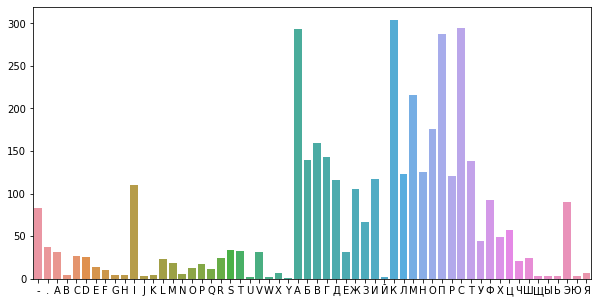

In [540]:
plt.figure(figsize=(10, 5))
sns.barplot(x=values.index, y=values.values)

In [55]:
abbreviations_decodes = {
    'АД': 'Артериальное давление',
    'ПМЖА': 'Передняя межжелудочковая артерия',
    'КАГ': 'Коронарная ангиография',
    'ПКА': 'Правая коронарная артерия',
    'ЭКГ': 'Электрокардиография',
    'ИМ': 'Инфаркт миокарда',
    'ОА': 'Огибающая артерия',
    'ЛЖ': 'Левый желудок',
    'ИБС': 'Ишемическая болезнь сердца',
    'ГБ': 'Гипертоническая болезнь',
    'РТСА': 'Перкутанная транслюминальная коронарная ангиопластика',
    'ПКА': 'Правая коронарная артерия',
    'СМП': 'Скорая медицинская помощь',
    'ФВ': 'Фракция выброса',
    'ОНМК': 'Острое нарушение мозгового кровообращения',
    'ОИМ': 'Острый инфаркт миокарда',
    'ДА': 'Диагональная артерия',
    'ЭХОКГ': 'Эхокардиография',
    'ОКС': 'Острый коронарный синдром',
}